#### Import Libraries

In [1]:
import pandas as pd
import urllib
import json
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import os

#### Create Connection to SQLLite database

In [4]:
conn = sqlite3.connect('ml_project_final.db')

#### Unemployment

#### POVERTY

In [36]:
poverty_url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT,SAEPOVALL_PT&for=county:*&time={0}'
years = range(2008,2017)

poverty_final_df = pd.DataFrame()
for year in years:
    poverty_txt = urllib.request.urlopen(poverty_url.format(year)).read() 
    poverty_list = json.loads(poverty_txt)
    current = pd.DataFrame(poverty_list[1:], columns=poverty_list[0]) 
    poverty_final_df = pd.concat((poverty_final_df, current))
poverty_final_df.head(5)

,NAME,SAEPOVRTALL_PT,SAEPOVALL_PT,time,state,county
0,Autauga County,10.7,5366,2008,01,001
1,Baldwin County,9.9,17110,2008,01,003
2,Barbour County,24.5,6399,2008,01,005
3,Bibb County,18.5,3753,2008,01,007
4,Blount County,13.1,7461,2008,01,009


In [5]:
poverty_final_df.shape
poverty_final_df.to_csv('poverty_final.csv')

In [37]:
poverty_final_df['time'].value_counts()

2011    3143
2010    3143
2012    3143
2013    3143
2009    3143
2016    3142
2014    3142
2008    3142
2015    3142
Name: time, dtype: int64

#### HEALTH

In [12]:
health_url = 'https://api.census.gov/data/timeseries/healthins/sahie?get=NIC_PT,NAME,NUI_PT&for=county:*&time={0}'
years = range(2008,2017)

final_health_df = pd.DataFrame()
for year in years:
    health_txt = urllib.request.urlopen(health_url.format(year)).read() 
    health_list = json.loads(health_txt)
    current = pd.DataFrame(health_list[1:], columns=health_list[0]) 
    final_health_df = pd.concat([final_health_df, current])
final_health_df.head(5)

,NIC_PT,NAME,NUI_PT,time,state,county
0,38474,"Autauga County, AL",5880,2008,01,001
1,120301,"Baldwin County, AL",23631,2008,01,003
2,18370,"Barbour County, AL",3934,2008,01,005
3,14321,"Bibb County, AL",3147,2008,01,007
4,39426,"Blount County, AL",9482,2008,01,009


In [8]:
final_health_df.shape
final_health_df.to_csv('health_final.csv')

In [9]:
final_health_df['time'].value_counts()

2009    3143
2010    3143
2013    3143
2011    3143
2012    3143
2016    3142
2014    3142
2008    3142
2015    3142
Name: time, dtype: int64

# Unemployement

In [32]:
unempl_folder = 'unemployment'
files = os.listdir(unempl_folder)
final_unempl_df = pd.DataFrame()
for file in files:
    filepath = os.path.join(unempl_folder, file)
    current = pd.read_csv(filepath)
    final_unempl_df = pd.concat((final_unempl_df, current))

final_unempl_df['time'] = final_unempl_df['time'].astype(str)
final_unempl_df['state'] = final_unempl_df['state'].apply(lambda x: '{0:02d}'.format(x))
final_unempl_df['county'] = final_unempl_df['county'].apply(lambda x: '{0:03d}'.format(x))
final_unempl_df.head()

,lauscode,state,county,NAME,time,blank,laborforce,employed,unemployed,unemployed_percentage
0,CN0100100000000,01,001,"Autauga County, AL",2008,NaN,"24,687","23,420","1,267",5.1
1,CN0100300000000,01,003,"Baldwin County, AL",2008,NaN,"83,223","79,372","3,851",4.6
2,CN0100500000000,01,005,"Barbour County, AL",2008,NaN,"10,161","9,267",894,8.8
3,CN0100700000000,01,007,"Bibb County, AL",2008,NaN,"8,749","8,241",508,5.8
4,CN0100900000000,01,009,"Blount County, AL",2008,NaN,"26,698","25,453","1,245",4.7


In [34]:
final_unempl_df.to_csv('unemployement_final.csv')
final_unempl_df['time'].value_counts()

2011    3219
2016    3219
2014    3219
2010    3219
2012    3219
2015    3219
2013    3219
2008    3217
2009    3217
Name: time, dtype: int64

#### Joining Health and Poverty dataframes to produce ONE data set

In [38]:
fulldata = pd.merge(left=final_health_df, right=poverty_final_df.iloc[:,[1,2,3,4,5]], on=['state', 'county', 'time'], how='inner')
fulldata = pd.merge(left=fulldata, right=final_unempl_df.iloc[:,[1,2,4,9]], on=['state', 'county', 'time'], how='inner')
fulldata.head()
fulldata.shape
fulldata['State'] = fulldata['NAME'].apply(lambda State: State.split(',')[-1])
fulldata['County'] = fulldata['NAME'].apply(lambda State: State.split(',')[0])
fulldata.head(5)

fulldata.to_csv('fulldata1.csv')

In [39]:
fulldata.head()

,NIC_PT,NAME,NUI_PT,time,state,county,SAEPOVRTALL_PT,SAEPOVALL_PT,unemployed_percentage,State,County
0,38474,"Autauga County, AL",5880,2008,01,001,10.7,5366,5.1,AL,Autauga County
1,120301,"Baldwin County, AL",23631,2008,01,003,9.9,17110,4.6,AL,Baldwin County
2,18370,"Barbour County, AL",3934,2008,01,005,24.5,6399,8.8,AL,Barbour County
3,14321,"Bibb County, AL",3147,2008,01,007,18.5,3753,5.8,AL,Bibb County
4,39426,"Blount County, AL",9482,2008,01,009,13.1,7461,4.7,AL,Blount County


#### Cleaning Up the dataset

In [40]:
fulldata = fulldata[(fulldata == "N/A").sum(axis=1) == 0].copy()
fulldata.to_csv('full_data_final.csv')
fulldata.head()

,NIC_PT,NAME,NUI_PT,time,state,county,SAEPOVRTALL_PT,SAEPOVALL_PT,unemployed_percentage,State,County
0,38474,"Autauga County, AL",5880,2008,01,001,10.7,5366,5.1,AL,Autauga County
1,120301,"Baldwin County, AL",23631,2008,01,003,9.9,17110,4.6,AL,Baldwin County
2,18370,"Barbour County, AL",3934,2008,01,005,24.5,6399,8.8,AL,Barbour County
3,14321,"Bibb County, AL",3147,2008,01,007,18.5,3753,5.8,AL,Bibb County
4,39426,"Blount County, AL",9482,2008,01,009,13.1,7461,4.7,AL,Blount County


#### Converting some data points to FLOAT for calculations

In [42]:
mydata = fulldata.iloc[:, [0,2,6,8]].astype(float)
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT,unemployed_percentage
0,38474.0,5880.0,10.7,5.1
1,120301.0,23631.0,9.9,4.6
2,18370.0,3934.0,24.5,8.8
3,14321.0,3147.0,18.5,5.8
4,39426.0,9482.0,13.1,4.7


#### Adding percentage UnInsured column 

In [43]:
mydata['uninsured_prctn'] = mydata['NUI_PT']/(mydata['NUI_PT'] + mydata['NIC_PT'])*100
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT,unemployed_percentage,uninsured_prctn
0,38474.0,5880.0,10.7,5.1,13.256978
1,120301.0,23631.0,9.9,4.6,16.418170
2,18370.0,3934.0,24.5,8.8,17.638092
3,14321.0,3147.0,18.5,5.8,18.015800
4,39426.0,9482.0,13.1,4.7,19.387421


#### "X" FEATURE (% POVERTY) , column 3(index 2). Make a numpy array

In [46]:
X = mydata.loc[:,['SAEPOVRTALL_PT','unemployed_percentage']].values
X

array([[10.7,  5.1],
       [ 9.9,  4.6],
       [24.5,  8.8],
       ...,
       [10.6,  5.7],
       [13.1,  4.7],
       [10.7,  4.9]])

#### "y" TARGET(% UNINSURED) , column 4(index 3), make a numpy array

In [47]:
y = mydata.loc[:,'uninsured_prctn'].values
#y = mydata.iloc[:,[3]].values
y

array([13.25697795, 16.41816969, 17.63809182, ..., 12.56897609,
       16.70822943, 14.35218325])

#### Find correlation between Poverty and Uninsured, using Python "corr" function.
#### Corelations are from -1 to +1 (-1 means -ve corelation, +1 means +ve corelation)
#### Based on the corelation results below there appears to be a 42% corelation between % Poverty and % Uninsured 

In [49]:
mydata.loc[:,['SAEPOVRTALL_PT','unemployed_percentage','uninsured_prctn']].corr()

,SAEPOVRTALL_PT,unemployed_percentage,uninsured_prctn
SAEPOVRTALL_PT,1.000000,0.475397,0.422407
unemployed_percentage,0.475397,1.000000,0.289135
uninsured_prctn,0.422407,0.289135,1.000000


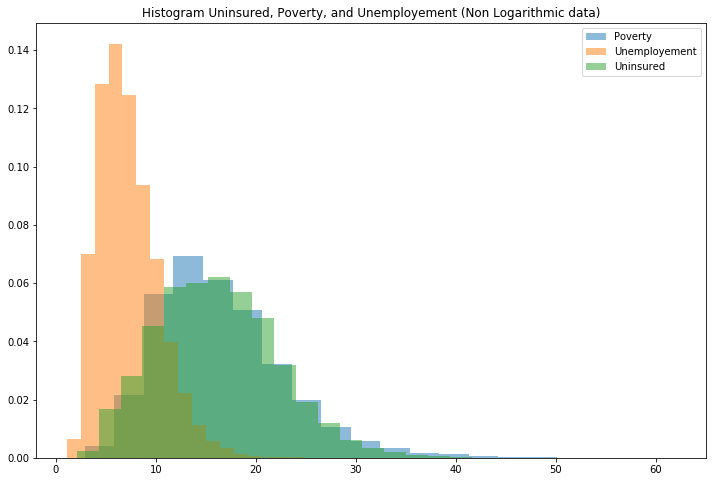

In [53]:
plt.figure(figsize=(12,8))
plt.hist(mydata.loc[:,'SAEPOVRTALL_PT'], bins=20, density=True, label='Poverty', alpha = 0.5)
plt.hist(mydata.loc[:,'unemployed_percentage'], bins=20, density=True, label='Unemployement', alpha = 0.5)
plt.hist(mydata.loc[:,'uninsured_prctn'], bins=20, density=True, label='Uninsured', alpha = 0.5)
#plt.hist(X_test, bins=20, density=True, label='Poverty', alpha = 0.5)
#plt.hist(y_test, bins=20, density=True, label='Uninsured', alpha = 0.5)
plt.title('Histogram Uninsured, Poverty, and Unemployement (Non Logarithmic data)')
plt.legend()

#### Adding Log of poverty and uninsured Transformation to the dataframe
#### Based on results below the corelation now is 47 %

In [51]:
mydata['Log_uninsured_prctn'] = np.log(mydata['uninsured_prctn'])
mydata['Log_SAEPOVRTALL_PT'] = np.log(mydata['SAEPOVRTALL_PT'])
mydata['Log_unemployed_percentage'] = np.log(mydata['unemployed_percentage'])
mydata.loc[:,['Log_uninsured_prctn','Log_SAEPOVRTALL_PT', 'Log_unemployed_percentage']].corr()

,Log_uninsured_prctn,Log_SAEPOVRTALL_PT,Log_unemployed_percentage
Log_uninsured_prctn,1.000000,0.471177,0.320151
Log_SAEPOVRTALL_PT,0.471177,1.000000,0.478856
Log_unemployed_percentage,0.320151,0.478856,1.000000


In [54]:
mydata.to_csv('project_data_NONEED.csv')

#### Applying ML methodologies. Split the data into two groups Train and Test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=50)
X_test

array([[ 9.8,  4.3],
       [20.7, 12.3],
       [17.7,  7.1],
       ...,
       [12.7,  8.6],
       [22.8, 15.9],
       [29.3,  3.8]])

#### Create a Linear Regression Object

In [57]:
lr = LinearRegression()

#### Train the model

In [58]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Accuracy of the test data

In [59]:
#lr.score(X_train, y_train) which one to use for r2 score : train or test
# r-squared is between 0 and 1, higher is better in terms of performance
lr.score(X_test, y_test) 

0.1871047962664566

#### Predict (uninsured) based on the known Poverty data

In [60]:
#### Predicted values(should this be with test data , train data or original data)
#y_pred = lr.predict(X)
y_pred = lr.predict(X)
y_pred

array([13.63628593, 13.24444937, 19.30969001, ..., 13.73336262,
       14.39291731, 13.59219348])

In [61]:
#### Scatter plot uninsured_percent and poverty_percent
#### Non Logarithmic data values

Text(0.5,1,'Scatter Plot Uninsured vs Unemployed (Non Logarithmic data)')

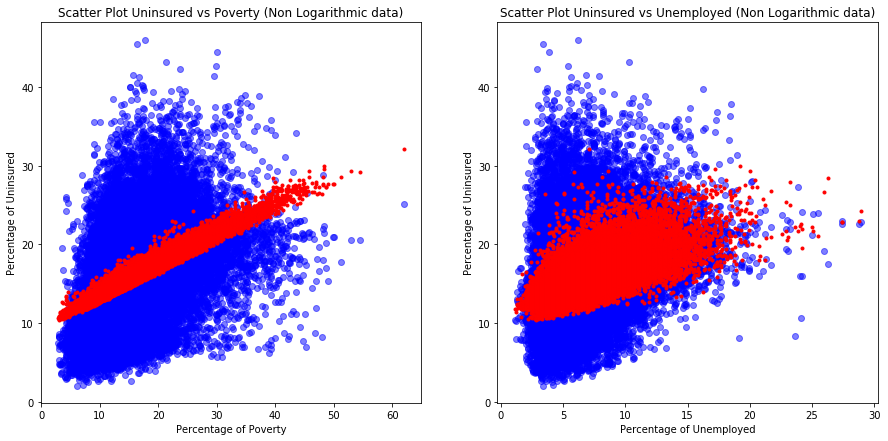

In [67]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1) # number of rows, number of columns, plot number
plt.plot(X[:,0], y, 'bo', alpha = 0.5)
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X[:,0],y_pred, 'r.')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs Poverty (Non Logarithmic data)')

plt.subplot(1,2,2)
plt.plot(X[:,1], y, 'bo', alpha = 0.5)
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X[:,1],y_pred, 'r.')
plt.xlabel('Percentage of Unemployed')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs Unemployed (Non Logarithmic data)')

In [ ]:
#### Histogram of Non Log poverty and Uninsured , notice long tail


In [ ]:
# becuase at a specific poverty (e.g., 5%) the variation of uninsured is high (from 5% to 25%), 
# it makes the prediction difficult and the prediction error could be large.
# becuase at a specific unemployed (e.g., 5%) the variation of uninsured is very high (from 5% to 45%), 
# it makes the prediction difficult and the prediction error could be large.

#### Scatter plot of the LOGARITHMIC values of Uninsured vs Poverty

In [68]:
X_log = np.log(X)
y_log = np.log(y)

#### Histogram of the LOG values of Uninsured vs Poverty, shape is closer to a Bell Curve

#### Split the LOG data into test and train

In [69]:
X_log_train, X_log_test, y_log_train, y_log_test = \
        train_test_split(X_log, y_log, test_size=0.70, random_state=50)

In [70]:
X_log_test

array([[2.28238239, 1.45861502],
       [3.0301337 , 2.50959926],
       [2.87356464, 1.96009478],
       ...,
       [2.87919846, 1.90210753],
       [2.61739583, 1.06471074],
       [2.96527307, 2.09186406]])

#### Create a Linear Regression Object

In [71]:
lr = LinearRegression()

#### Train the model

In [72]:
lr.fit(X_log_train, y_log_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
lr.score(X_log_test, y_log_test)

0.23379175028514354

In [74]:
#y_log_pred = lr.predict(X_log_test) ###Graph does not plot with this!
y_log_pred = lr.predict(X_log) # this is for plotting

Text(0.5,1,'Scatter of the LOG of Uninsured vs Unemployed ')

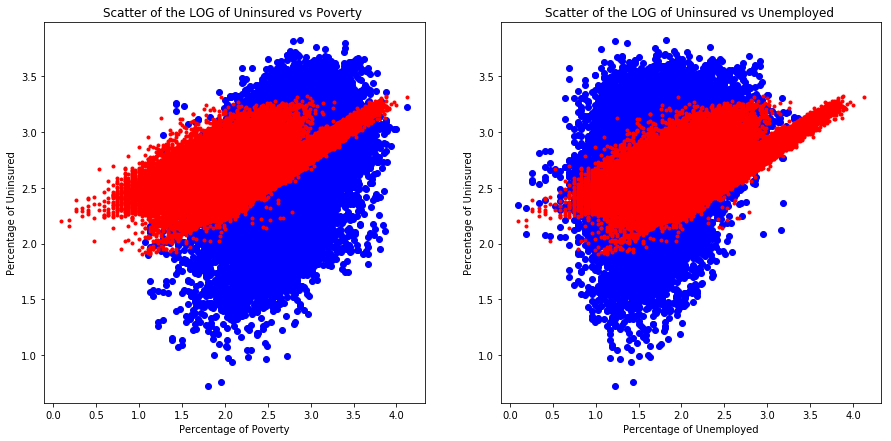

In [76]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(X_log[:,0], y_log, 'bo')
plt.plot(X_log,y_log_pred, 'r.')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured') 
plt.title('Scatter of the LOG of Uninsured vs Poverty ')


plt.subplot(1,2,2)
plt.plot(X_log[:,1], y_log, 'bo')
plt.plot(X_log,y_log_pred, 'r.')
plt.xlabel('Percentage of Unemployed')
plt.ylabel('Percentage of Uninsured') 
plt.title('Scatter of the LOG of Uninsured vs Unemployed ')

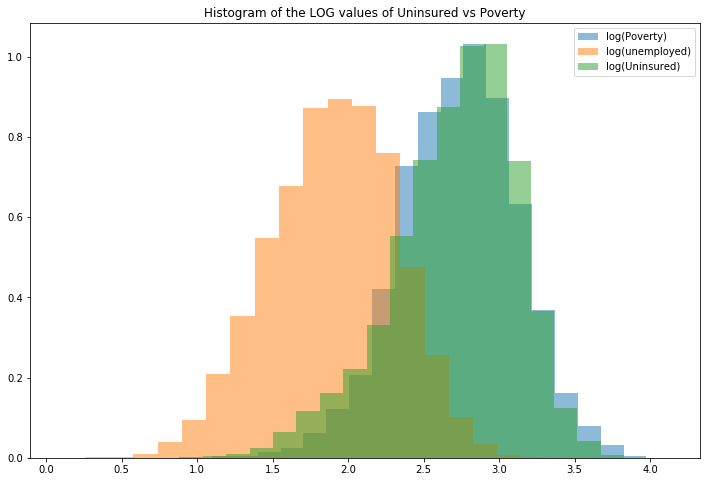

In [77]:
plt.figure(figsize=(12,8))
plt.hist(X_log_test[:,0], bins=20, density=True, label='log(Poverty)', alpha = 0.5)
plt.hist(X_log_test[:,1], bins=20, density=True, label='log(unemployed)', alpha = 0.5)
plt.hist(y_log_test, bins=20, density=True, label='log(Uninsured)', alpha = 0.5)
plt.title('Histogram of the LOG values of Uninsured vs Poverty')
plt.legend()

## Final Analysis of the Multivariant Linear Regression 
#### We see a positive correlation between % of poverty and % of uninsured people. It means that
#### there is a direct relationship between these two parameters. In other words, if % of poverty
#### goes up, the % of unisnured people is also goes up. However, the correlation value is only 0.42 (linear) to 0.47 (logarithmic)
#### which means the correlation is fairly strong. Also from the regression R2, we get 0.17(linear) to 0.22 (log) 
#### which is not very good. Therefore, it seems modeling the exact % of uninsured people from % of poverty is difficult, but
#### the graph and correlation show a positive relationship.

# Random Forest

In [78]:
myrf = RandomForestRegressor()

In [84]:
myrf.fit(X_train, y_train)
myrf.score(X_test, y_test)

-0.055161065148432886

In [85]:
myrf.score(X_train, y_train)

0.6681021991826922

In [80]:
y_pred = myrf.predict(X)

In [ ]:
# random forest prediction does not fall on a straight line and can have any shape

Text(0.5,1,'Random Forest')

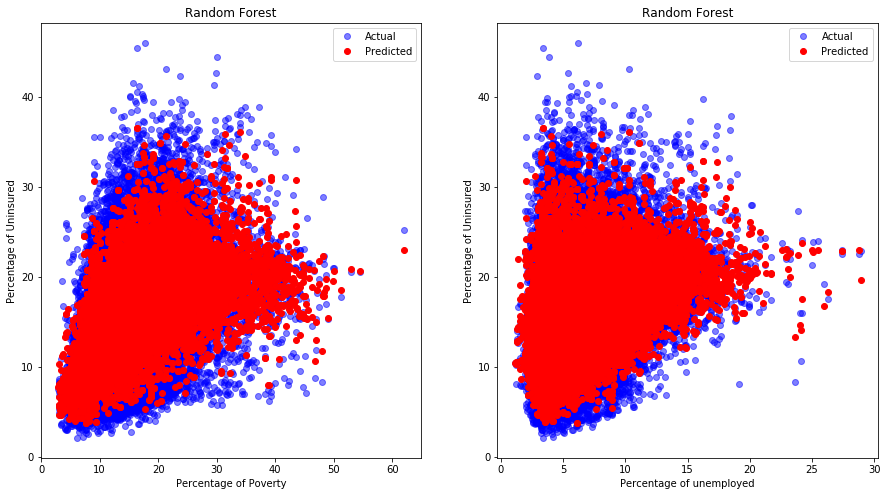

In [86]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(X[:,0], y, 'bo', label='Actual', alpha = 0.5)
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X[:,0],y_pred, 'ro', label='Predicted')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs Poverty (Non Logarithmic data)')
plt.legend()
plt.title('Random Forest')


plt.subplot(1,2,2)
plt.plot(X[:,1], y, 'bo', label='Actual', alpha = 0.5)
#plt.plot(X_test, y_test, 'bo', alpha = 0.5)
plt.plot(X[:,1],y_pred, 'ro', label='Predicted')
plt.xlabel('Percentage of unemployed')
plt.ylabel('Percentage of Uninsured')
plt.title('Scatter Plot Uninsured vs unemployed (Non Logarithmic data)')
plt.legend()
plt.title('Random Forest')